In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from image_extractor import DataSetup
data = DataSetup()

OS: Windows
0 :  overall_geometry
1 :  overall_rgb
2 :  overall_hsv
3 :  n1
4 :  structure
5 :  n2
6 :  moldered
7 :  color_grid
8 :  color_grid_2
9 :  glcm_grid
10 :  comp_hsv
11 :  glcm_2
12 :  lbp
13 :  haralick


In [57]:
data.concat(dataID=[0, 8, 10, 12, 13])
model_dir = 'D:./TF_backup/mlp/' + data.model_name
checkpoint_dir = 'D:./TF_checkpoint/mlp/weight/'
print(model_dir)

input_shape = (data.length,)
batch_size = 8

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

x_test size: (1680, 443)
x_train size: (6720, 443)
y_test size: (1680, 14)
y_train size: (6720, 14)
Model name = ' overall_geometry_color_grid_2_comp_hsv_lbp_haralick.h5 '
D:./TF_backup/mlp/overall_geometry_color_grid_2_comp_hsv_lbp_haralick.h5


In [58]:
normalizer = layers.Normalization()
normalizer.adapt(data.x_train)

# Define model
input_layer = layers.Input(shape=input_shape)
norm = normalizer(input_layer)
den1 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(norm)
drop1 = layers.Dropout(0.2)(den1)
den2 = layers.Dense(1024, activation='relu', kernel_initializer='HeNormal')(drop1)
drop2 = layers.Dropout(0.2)(den2)
den3 = layers.Dense(512, activation='relu', kernel_initializer='HeNormal')(drop2)
drop3 = layers.Dropout(0.2)(den3)
den4 = layers.Dense(512, activation='relu', kernel_initializer='HeNormal')(drop3)
drop4 = layers.Dropout(0.2)(den4)
den5 = layers.Dense(14, activation='softmax')(drop4)
model = keras.Model(input_layer, den5)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.4,
    nesterov=True,
    name='SGD',
)

model.compile(
    optimizer=opt, 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )

In [59]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 443)]             0         
                                                                 
 normalization_7 (Normalizat  (None, 443)              887       
 ion)                                                            
                                                                 
 dense_35 (Dense)            (None, 1024)              454656    
                                                                 
 dropout_28 (Dropout)        (None, 1024)              0         
                                                                 
 dense_36 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_29 (Dropout)        (None, 1024)              0         
                                                           

In [60]:
epochs = 40
model.fit(data.x_train, data.y_train, batch_size=batch_size, shuffle=True, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/40
840/840 [==============================] - 5s 5ms/step - loss: 3.0551 - accuracy: 0.1379
Epoch 2/40
840/840 [==============================] - 4s 5ms/step - loss: 2.4280 - accuracy: 0.2436
Epoch 3/40
840/840 [==============================] - 4s 5ms/step - loss: 2.1508 - accuracy: 0.3064
Epoch 4/40
840/840 [==============================] - 4s 5ms/step - loss: 1.9276 - accuracy: 0.3646
Epoch 5/40
840/840 [==============================] - 4s 5ms/step - loss: 1.7939 - accuracy: 0.4040
Epoch 6/40
840/840 [==============================] - 4s 5ms/step - loss: 1.6632 - accuracy: 0.4458
Epoch 7/40
840/840 [==============================] - 4s 5ms/step - loss: 1.5948 - accuracy: 0.4719
Epoch 8/40
840/840 [==============================] - 4s 5ms/step - loss: 1.5223 - accuracy: 0.4905
Epoch 9/40
840/840 [==============================] - 4s 5ms/step - loss: 1.4677 - accuracy: 0.5046
Epoch 10/40
840/840 [==============================] - 4s 5ms/step - loss: 1.3987 - accuracy: 0.5201

In [61]:
score = model.evaluate(data.x_test, data.y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

53/53 [==============================] - 0s 2ms/step - loss: 0.9171 - accuracy: 0.6923
Test loss: 0.9171092510223389
Test accuracy: 0.6922619342803955


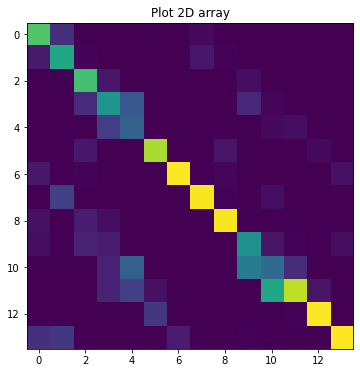

In [62]:
i = 0
cmatrix = np.zeros((14,14), dtype=np.int16)
bat = int(len(data.x_test)/60)
for i in range(0, len(data.x_test),bat):
    result = model.predict_on_batch(data.x_test[i:i+bat])
    ans = data.y_test[i:i+bat]
    for j in range(bat):
        id1 = np.argmax(result[j])
        id2 = np.argmax(ans[j])
        cmatrix[id1, id2] = cmatrix[id1][id2] + 1

cmatrix = np.absolute(cmatrix)
# print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()

In [63]:
acc = []
for i in range(14):
    acc.append(np.round(cmatrix[i][i]/120,3))
print(acc)
print(np.mean(acc))

[0.675, 0.55, 0.65, 0.483, 0.292, 0.808, 0.925, 0.917, 0.917, 0.467, 0.325, 0.833, 0.925, 0.925]
0.6922857142857144
